# Ambient Sound Levels

In [8]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import kaooi
import xrsignal as xrs
import scipy
from dask.distributed import Client
import seaborn as sns
import pathlib

In [6]:
import ooipy

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 1.48 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34677,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 1.48 TiB
Comm: tcp://127.0.0.1:35089,Total threads: 4
Dashboard: http://127.0.0.1:44037/status,Memory: 188.94 GiB
Nanny: tcp://127.0.0.1:42597,


In [56]:
calibration_path = f'{pathlib.Path(ooipy.__file__).resolve().parent}/hydrophone/calibration_by_assetID.csv'
calibration = pd.read_csv(calibration_path, header=[0, 1])

In [227]:
counts_per_volt = 2796202.66667 

bb_calib = { # counts / P
    'LJ01C':10**((-168.2 + 128.9)/20), # dV rel V / uPA | dB rel counts / V
    'PC01A':10**((-170.2 + 128.9)/20),
    'PC03A':10**((-170.5 + 128.9)/20),
    'LJ03A':10**((-168.8 + 128.9)/20),
    'LJ01D':10**((-170.5 + 128.9)/20),
    'LJ01A':10**((-168.9 + 128.9)/20),
}

In [228]:
lf_calibrations = {}
for node in ['AXCC1','AXEC2','AXBA1','HYS14','HYSB1']:
    counts_per_Pa = float(calibration[f'{node}-HDH']['0 phase'].loc[0])
    lf_calibrations[node] = counts_per_Pa

In [229]:
# open dataset and slice to 40 min around reception
ds_lf = kaooi.open_ooi_lf().sel({'time':slice(35*60, 75*60)})
ds_bb = kaooi.open_ooi_bb().sel({'time':slice(35*60, 75*60)})

In [257]:
ds_lf_cal = (ds_lf[['AXCC1','AXEC2','AXBA1','HYS14', 'HYSB1']] / lf_calibrations)
ds_bb_cal = (ds_bb[['LJ01C','PC01A','PC03A','LJ01D','LJ01A']] / bb_calib)

In [258]:
ds_lf_f = (xrs.welch(ds_lf_cal, dim='time', fs=200, nperseg=4096, dB=True, average='median').rename({'time_frequency':'frequency'}).isel({'time':0}) - 20*np.log10(1e-6)).compute()
ds_bb_f = xrs.welch(ds_bb_cal, dim='time', fs=500, nperseg=4096, dB=True, average='median').rename({'time_frequency':'frequency'}).isel({'time':0}).compute()

/gscratch/coenv/jhrag/miniconda/envs/kb/lib/python3.12/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 103.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/gscratch/coenv/jhrag/miniconda/envs/kb/lib/python3.12/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 130.02 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [259]:
lf_f_avg = ds_lf_f.sel({'frequency':slice(37.5, 112.5)}).mean('frequency').dropna('transmission')
bb_f_avg = ds_bb_f.sel({'frequency':slice(37.5, 112.5)}).mean('frequency').dropna('transmission')

lf_f_avg = lf_f_avg.where(~np.isinf(lf_f_avg), drop=True)
bb_f_avg = bb_f_avg.where(~np.isinf(bb_f_avg), drop=True)

In [260]:
lf_perc = lf_f_avg.quantile([0.25 ,0.5, 0.75], dim='transmission')
bb_perc = bb_f_avg.quantile([0.25 ,0.5, 0.75], dim='transmission')

In [261]:
percentiles_lf = ds_lf_f.sel({'frequency':slice(37.5,112.5)}).mean('frequency').quantile([0.25, 0.5, 0.75], dim='transmission')
precentiles_lf = percentiles_lf.where(~np.isinf(percentiles_lf), np.nan)
percentiles_bb = ds_bb_f.sel({'frequency':slice(37.5,112.5)}).mean('frequency').quantile([0.25, 0.5, 0.75], dim='transmission')
precentiles_bb = percentiles_bb.where(~np.isinf(percentiles_bb), np.nan)

In [274]:
percentiles_bb = ds_bb_f.quantile([0.01, .25, 0.5, 0.75, 0.99], dim='transmission')
precentiles_bb = percentiles_bb.where(~np.isinf(percentiles_bb), np.nan)

In [279]:
sns.set_palette('Set1')

(60.0, 130.0)

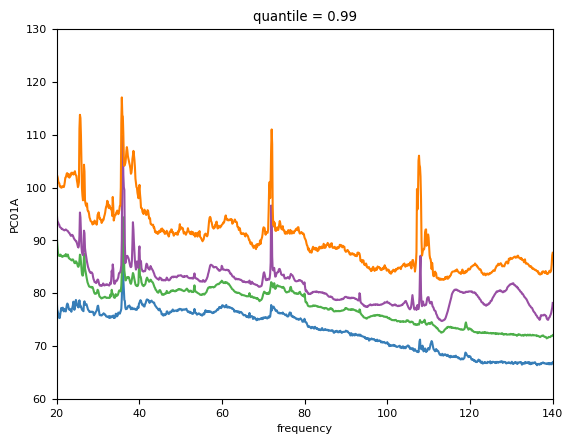

In [283]:
for k in range(5):
    percentiles_bb['PC01A'][k,:].plot()

plt.xlim([20,140])
plt.ylim([60,130])

In [262]:
lf_perc.isel({'quantile':1})

<xarray.Dataset> Size: 48B
Dimensions:   ()
Coordinates:
    quantile  float64 8B 0.5
Data variables:
    AXCC1     float64 8B 57.51
    AXEC2     float64 8B 58.83
    AXBA1     float64 8B 55.7
    HYS14     float64 8B 61.44
    HYSB1     float64 8B 61.45

In [263]:
bb_perc.isel({'quantile':1})

<xarray.Dataset> Size: 48B
Dimensions:   ()
Coordinates:
    quantile  float64 8B 0.5
Data variables:
    LJ01C     float64 8B 72.16
    PC01A     float64 8B 79.91
    PC03A     float64 8B 76.67
    LJ01D     float64 8B 71.42
    LJ01A     float64 8B 61.44

In [264]:
lf_perc.isel({'quantile':2}).drop_vars('quantile') - lf_perc.isel({'quantile':1}).drop_vars('quantile')

<xarray.Dataset> Size: 40B
Dimensions:  ()
Data variables:
    AXCC1    float64 8B 2.721
    AXEC2    float64 8B 2.409
    AXBA1    float64 8B 2.344
    HYS14    float64 8B 2.086
    HYSB1    float64 8B 2.579

In [265]:
bb_perc.isel({'quantile':2}).drop_vars('quantile') - bb_perc.isel({'quantile':1}).drop_vars('quantile')

<xarray.Dataset> Size: 40B
Dimensions:  ()
Data variables:
    LJ01C    float64 8B 1.584
    PC01A    float64 8B 1.638
    PC03A    float64 8B 1.528
    LJ01D    float64 8B 4.027
    LJ01A    float64 8B 8.808

In [195]:
sns.set_palette('Set3')

In [220]:
lf_perc.isel({'quantile':1})

<xarray.Dataset> Size: 32B
Dimensions:   ()
Coordinates:
    quantile  float64 8B 0.5
Data variables:
    AXCC1     float64 8B 57.52
    AXEC2     float64 8B 58.86
    AXBA1     float64 8B 55.78

In [217]:
lf_perc.isel({'quantile':2}).drop_vars('quantile') - lf_perc.isel({'quantile':1}).drop_vars('quantile')

<xarray.Dataset> Size: 24B
Dimensions:  ()
Data variables:
    AXCC1    float64 8B 2.853
    AXEC2    float64 8B 2.486
    AXBA1    float64 8B 2.333

(45.0, 95.0)

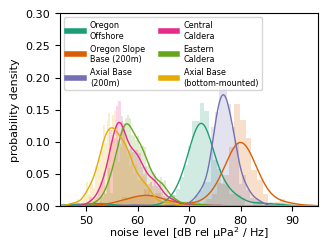

In [222]:
plt.rcParams.update({'font.size': 8})
fig = plt.figure(figsize=(3.33, 2.5))

colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02']
labels = {
    'LJ01C':'Oregon\nOffshore',
    'PC01A':'Oregon Slope\nBase (200m)',
    'PC03A':'Axial Base \n(200m)'
}
for k, node in enumerate(['LJ01C','PC01A','PC03A']):

    spectral_values = bb_f_avg[node].dropna('transmission').values
    qs = np.quantile(spectral_values, [0.25, 0.5, 0.75])
    kernel = scipy.stats.gaussian_kde(spectral_values)
    _ = plt.hist(spectral_values, bins=60, alpha=0.2,  density=True, color=colors[k])
    SPL = np.linspace(45,95,1000)
    plt.plot(SPL, kernel(SPL), c=colors[k], label=labels[node], lw=1)

labels = {
    'AXCC1':'Central\nCaldera',
    'AXEC2':'Eastern\nCaldera',
    'AXBA1':'Axial Base\n(bottom-mounted)'
}
for k, node in enumerate(['AXCC1','AXEC2','AXBA1']):

    spectral_values = lf_f_avg[node].dropna('transmission').values
    qs = np.quantile(spectral_values, [0.25, 0.5, 0.75])
    kernel = scipy.stats.gaussian_kde(spectral_values)
    _ = plt.hist(spectral_values, bins=60, alpha=0.2,  density=True, color=colors[k+3])
    SPL = np.linspace(45,95,1000)
    plt.plot(SPL, kernel(SPL), c=colors[k+3], label=labels[node], lw=1)
    
plt.xlabel(r'noise level [dB rel $\mathrm{\mu Pa^2}$ / Hz]', labelpad=-1)
legend = plt.legend(fontsize=5.8, loc='upper left', ncols=2)
# change the line width for the legend
for line in legend.get_lines():
    line.set_linewidth(4.0)

    
plt.ylabel('probability density')
plt.ylim([0,0.3])
plt.xlim([45,95])
#fig.savefig('figures/ambient_sound.pdf', bbox_inches='tight')

## Calculate PG

In [7]:
import kaooi
import xarray as xr
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

In [4]:
rep = kaooi.construct_replica(sampling_rate=1000).values

In [8]:
Rxx = np.correlate(rep, rep, mode='same')

In [41]:
PG_full = 20*np.log10(np.max(Rxx)/(3*np.std(Rxx[20000:])))

In [34]:
b,a = signal.butter(4, 85/(1000/2), )

In [35]:
f,w = signal.freqz(b,a, fs=1000)

In [39]:
repf = signal.filtfilt(b,a,rep)
Rxxf = np.correlate(repf, rep, mode='same')

In [43]:
PG_part = 20*np.log10(np.max(Rxxf)/(3*np.std(Rxx[20000:])))

In [45]:
PG_full - PG_part

np.float64(2.8286226493176656)